# ISPR: midterm 3
## Assignment 5
*The dataset contains real and fake news, including their title, text, subject, and date. The objective is to train a binary classifier to recognize fake news. You are free to choose the model's architecture, but you should describe and justify your design choices.
Notice that the fake and real news in the dataset are balanced. However, in the real world, real news are much more frequent than fake ones (hopefully). Simulate the effect of the data imbalance by undersampling/oversampling one of the classes in the training set and compute the test accuracy on a (balanced) test set. Then, try to use a mechanism to make the training robust to imbalances, such as weighting the loss for the samples depending on their class. Discuss the results of this mitigation.*

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:0

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.1
Uninstalling transformers-4.29.1:
  Successfully uninstalled transformers-4.29.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.1-py3-none-any.whl (7.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# imports
import os
import torch 
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from datasets import DatasetDict, Dataset, load_metric

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import evaluate
from imblearn.over_sampling import RandomOverSampler

In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 23

set_seed(seed)

from distutils.version import LooseVersion as LV

if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 2.0.0+cu118 Device: cuda [Tesla T4]


<ipython-input-4-9c8cc9a22350>:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(torch.__version__) >= LV("1.0.0"))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/ISPR/midterm_3/archive/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/ISPR/midterm_3/archive/True.csv')

fake['class']='fake'
true['class']='true'

frames = [fake, true]
data = pd.concat(frames)

fake    23481
true    21417
Name: class, dtype: int64


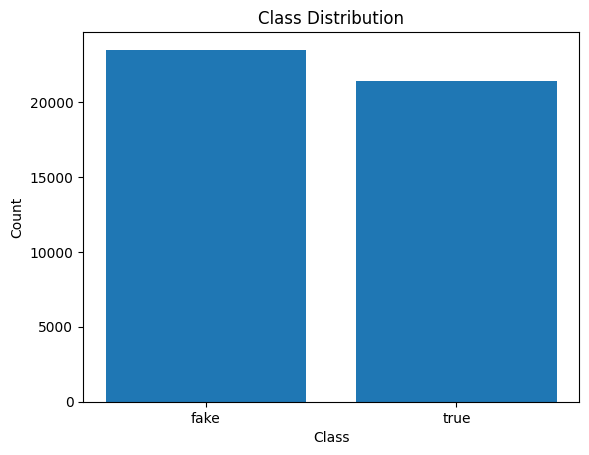

In [ ]:
#exploring classes distribution
class_counts = data['class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

print (class_counts)
plt.show()

In [ ]:
#train test split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

## Oversampling *True* class in the training set


Using *Sklearn* RandomOversampling method,  it has been oversampled the *True* class in the training data. New oversampled train presents an umbalanced distribution of the classes: 80% of the records are real news, 20% fake news.




In [ ]:
X= train_df.iloc[:,:3]
y= train_df['class']

In [ ]:
oversampler = RandomOverSampler(sampling_strategy={'true': 39000})
oversampled_X, oversampled_y = oversampler.fit_resample(X, y)

oversampled_train = pd.DataFrame(data=oversampled_X, columns=X.columns)
oversampled_train['class'] = oversampled_y

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (39000) in class true will be larger than the number of samples in the majority class (class #fake -> 18748)
  warnings.warn(


In [ ]:
oversampled_train

,title,text,subject,class
0,Turkey's Erdogan says U.S. Jerusalem decision ...,ATHENS (Reuters) - Turkish President Tayyip Er...,worldnews,true
1,BREAKING: Trump Reportedly Considering Ted Cru...,"Ted Cruz would be fair, honest and most of all...",politics,fake
2,Trump chief of staff's Civil War comment spark...,WASHINGTON (Reuters) - White House Chief of St...,politicsNews,true
3,Saudi Arabia welcomes new U.S. strategy toward...,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,politicsNews,true
4,Trump arrives in Sicily ahead of Group of Seve...,"SIGONELLA, Italy (Reuters) - U.S. President Do...",politicsNews,true
...,...,...,...,...
57743,"U.S. lifts Sudan sanctions, wins commitment ag...",WASHINGTON (Reuters) - The United States lifte...,worldnews,true
57744,Senate panel delays vote on Trump trade nomine...,WASHINGTON (Reuters) - The Senate Finance Comm...,politicsNews,true
57745,Trump refugee order dashes hopes of Iraqis who...,NEW YORK (Reuters) - Iraqis who say their live...,politicsNews,true
57746,Virginia governor says confident campaign dono...,"WASHINGTON (Reuters) - Terry McAuliffe, Virgin...",politicsNews,true


true    39000
fake    18748
Name: class, dtype: int64


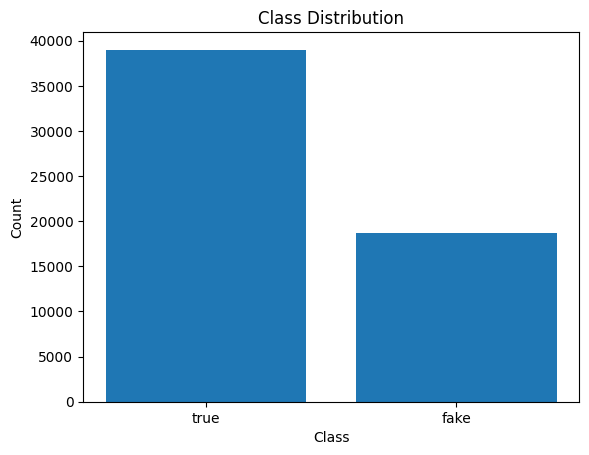

In [ ]:
#exploring new classes distribution
ov_class_counts = oversampled_train['class'].value_counts()
plt.bar(ov_class_counts.index, ov_class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

print (ov_class_counts)
plt.show()

## News classification using BERT

In [ ]:
#oversampled_train['train'] = train_df['title'] + '- ' + train_df['text'] + ' ' + train_df['date'] + ' ' + train_df['subject']

First of all, dataset has been prepared for the classification. The *replace_with_index* function  replaces the class labels in the DataFrame with numerical indices. Then, it has been instantatied a *DatasetDict* object containing train and test datasets, created using the Dataset.from_pandas function, which converts the Pandas DataFrames into Hugging Face Datasets.

In [ ]:
def replace_with_index(df, column_name, label_list=None):
    if label_list == None:
        label_list = list(df[column_name].unique())
    label_map = {label: idx for idx, label in enumerate(label_list)}
    df['label'] = df[column_name].map(label_map)
    return df, label_list

train_df, label_list = replace_with_index(oversampled_train, 'class')
test_df, label_list = replace_with_index(test_df, 'class')

dataset = DatasetDict ({
        "train": Dataset.from_pandas(train_df),
        "test": Dataset.from_pandas(test_df)
    })

The *compute_metrics* function takes the evaluation predictions (logits) and labels and computes the accuracy metric.

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Due to speed reason, it has been selected as model *DistilBertForSequenceClassification* from the Hugging Face library with the "distilbert-base-uncased" architecture, a distilled version of BERT specifically designed for sequence classification tasks.
It is also initialized a tokenizer that matches the architecture of the model.

In [ ]:
n_labels = 2

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= n_labels)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Training pipeline has been setup using the Trainer class from the Hugging Face library and specifying various training settings using a TrainingArguments object.

In [ ]:
def tokenize_function(examples):
      return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results", 
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    num_train_epochs=3, 
    logging_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/57748 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets['train']

Dataset({
    features: ['title', 'text', 'subject', 'class', 'label', 'input_ids', 'attention_mask'],
    num_rows: 57748
})

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.009500,11.415490,0.000223
2,0.001900,14.802499,0.000000


In [ ]:
trainer.evaluate()

## Make the training robust to imbalances

To address the data imbalance issue in  dataset they have been used class weighting. By assigning higher weights to the minority class (fake news), it is possible to ensure that the model pays more attention to this class during training.

Calculate the class weights based on the class distribution in the training dataset using the compute_class_weigth sklearn  class (0 is the true class and 1 is fake)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = {label: weight for label, weight in enumerate(class_weights)}

print(class_weights)


Update the training arguments to include the class weights in the loss calculation.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    logging_strategy="epoch",
    weight=class_weights
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
trainer.evaluate()